In [205]:
from system import *
from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

In [207]:
e = TradingWithRedditEnv('AMZN')
e._get_current_embeddings()

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

# Generating Experimental Data

In [204]:
# total_history = pd.DataFrame()
# with open("filtered_tickers.txt", "r") as src:
#     filtered_tickers = src.read().split("\n")

# agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
# # agents = [DQN, A2C, DDPG, ModelBasedAgent]
# for A in agents:
#     for ticker in tqdm(filtered_tickers[0:6]):
#         a = A()
#         e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
        
#         for i in range(3):
#             h_train = a.run_episode(e_train)
#             h_train['mode'] = 'train'
#             h_train['t'] = range(len(h_train))
#             h_train['episode'] = int(i + 1)
#             h_train['agent'] = a.name
#             total_history = pd.concat([total_history, h_train])
        
#         e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
#         h_test = a.run_episode(e_test)
#         h_test['mode'] = 'test'
#         h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
#         h_test['agent'] = a.name
#         total_history = pd.concat([total_history, h_test])

In [11]:
total_history

,date,ticker,rewards,actions,returns,prices,mode,t,episode,agent
Date,,,,,,,,,,
2014-01-06,2014-01-06,A,-9.951808,-1.0,0.004919,40.515022,train,0,1.0,Deep Q-Network
2014-01-07,2014-01-07,A,-0.143712,-1.0,-0.009451,41.094421,train,1,1.0,Deep Q-Network
2014-01-08,2014-01-08,A,-19.650867,1.0,0.002266,41.766811,train,2,1.0,Deep Q-Network
2014-01-09,2014-01-09,A,-10.068561,0.0,0.001694,41.781116,train,3,1.0,Deep Q-Network
2014-01-10,2014-01-10,A,0.000000,0.0,0.001694,42.153076,train,4,1.0,Deep Q-Network
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ABC,0.198998,-1.0,0.021312,70.760002,test,1251,NaN,Model-based
2018-12-26,2018-12-26,ABC,-0.384722,-1.0,0.017085,73.040001,test,1252,NaN,Model-based
2018-12-27,2018-12-27,ABC,-0.077519,-1.0,0.016234,73.529999,test,1253,NaN,Model-based


In [5]:
total_history['episode'].unique(), total_history['ticker'].unique(), total_history['agent'].unique()

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., nan]),
 array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC'], dtype=object),
 array(['Deep Q-Network', 'A2C', 'DDPG', 'Model-based without Text',
        'Model-based'], dtype=object))

In [208]:
import os
os.path.isfile('./training_history.csv')

True

In [209]:
if not os.path.isfile('./training_history.csv'):
    training_history = pd.DataFrame()
    N_EPISODES = 50
    with open("filtered_tickers.txt", "r") as src:
        filtered_tickers = src.read().split("\n")
    N_TICKERS = 30
    agents = [A2C, DDPG, DQN, ModelBased_NoText_Agent, ModelBasedAgent]
    for A in agents:
        for ticker in tqdm(filtered_tickers[0:N_TICKERS]):
            a = A()
            e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
            for i in range(N_EPISODES):
                h_train = a.run_episode(e_train)
    #             h_train['mode'] = 'train'
                h_train['t'] = range(len(h_train))
                h_train['episode'] = int(i + 1)
                h_train['agent'] = a.name
                training_history = pd.concat([training_history, h_train])
    training_history.to_csv('training_history.csv', index=False)
else:
    training_history = pd.read_csv('./training_history.csv')

In [210]:
training_history.agent.unique()

array(['Deep Q-Network', 'A2C', 'DDPG', 'Model-based without Text',
       'Model-based'], dtype=object)

In [211]:
# need to fix model-based data

In [242]:
training_history_proper = training_history[~(training_history.agent == 'Model-based')]

In [243]:
for ticker in tqdm(filtered_tickers[0:N_TICKERS]):
    a = A()
    e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
    for i in range(N_EPISODES):
        h_train = a.run_episode(e_train)
    #   h_train['mode'] = 'train'
        h_train['t'] = range(len(h_train))
        h_train['episode'] = int(i + 1)
        h_train['agent'] = a.name
        training_history_proper = pd.concat([training_history_proper, h_train])

100%|██████████| 30/30 [1:53:18<00:00, 226.63s/it]


In [250]:
training_history_proper.groupby(['agent', 'episode']).count()

date  ticker  rewards  actions  returns  \
agent                    episode                                             
A2C                      1        30150   30150    30150    30150    30150   
                         2        30150   30150    30150    30150    30150   
                         3        30150   30150    30150    30150    30150   
                         4        30150   30150    30150    30150    30150   
                         5        30150   30150    30150    30150    30150   
...                                 ...     ...      ...      ...      ...   
Model-based without Text 46       30150   30150    30150    30150    30150   
                         47       30150   30150    30150    30150    30150   
                         48       30150   30150    30150    30150    30150   
                         49       30150   30150    30150    30150    30150   
                         50       30150   30150    30150    30150    30150   

                                  prices      t  discounted_reward  
agent                    episode                                    
A2C                      1         30150  30150              30150  
                         2         30150  30150              30150  
                         3         30150  30150              30150  
                         4         30150  30150              30150  
                         5         30150  30150              30150  
...                                  ...    ...                ...  
Model-based without Text 46        30150  30150              30150  
                         47        30150  30150              30150  
                         48        30150  30150              30150  
                         49        30150  30150              30150  
                         50        30150  30150              30150  

[250 rows x 8 columns]

In [252]:
training_history = training_history_proper.sort_values('agent')

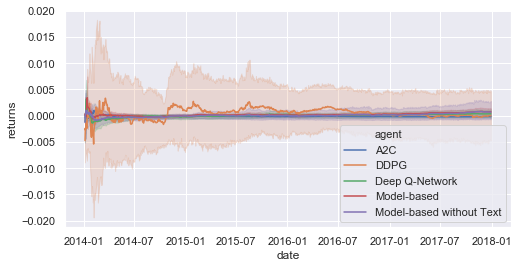

In [154]:
training_history = training_history.sort_values('agent')
sns.lineplot('date', 'returns', data=training_history[training_history.episode == 1], hue='agent')

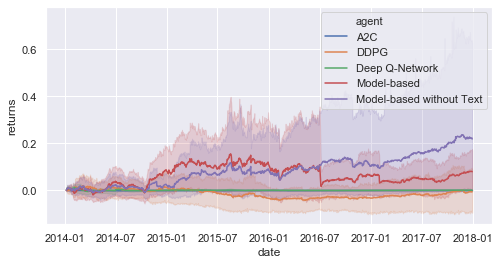

In [155]:
sns.lineplot('date', 'returns', data=training_history[training_history.episode == 10], hue='agent')

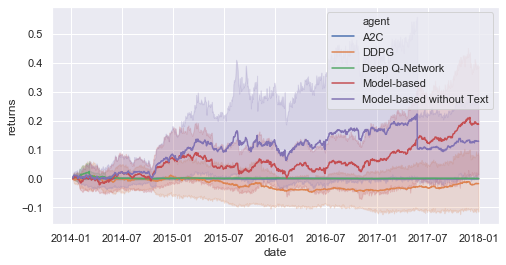

In [156]:
sns.lineplot('date', 'returns', data=training_history[training_history.episode == 50], hue='agent')

In [253]:
# training_history = total_history[(total_history['mode'] == 'train')]
training_history['discounted_reward'] = (training_history.t
                                             .apply( lambda x : np.power(a.gamma, x))
                                            * training_history.rewards)
rewards_df = (
    training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'})
        .groupby(['agent', 'episode'])
        .agg({'discounted_reward' : 'mean'})
#          .plot()
)

# total_history[(total_history.ticker == 'A') & (total_history['mode'] == 'train')]
# h = total_history
# h[h.mode == 'train']

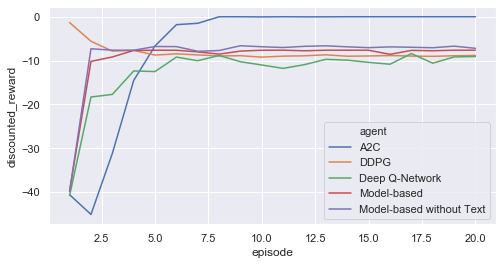

In [150]:
sns.set()
h = rewards_df.reset_index()
sns.lineplot('episode', 'discounted_reward', data=h[h.episode <= 20], hue='agent')

In [7]:
# rewards_df.reset_index(['agent', 'episode'], drop=False)

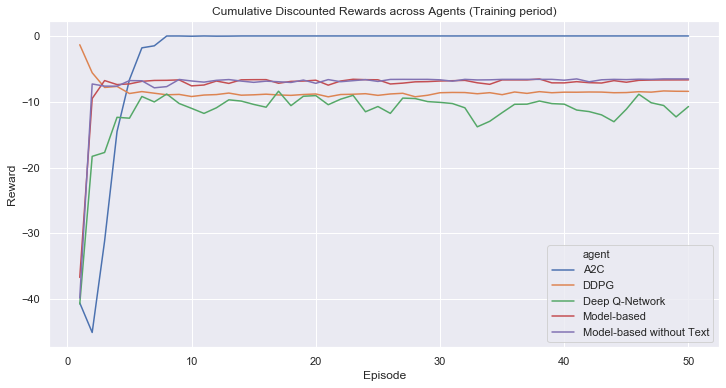

In [254]:
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=rewards_df.reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [143]:
sns.set('paper')
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=(training_history
                     .groupby(['agent', 'ticker', 'episode'])
                  )
        .agg({'discounted_reward' : 'sum'}).reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.savefig('plots/rewards-all-agents.png')
plt.show()

AttributeError: 'DataFrameGroupBy' object has no attribute 'sort_values'

In [95]:
test_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")

agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
# agents = [DQN, A2C, DDPG, ModelBasedAgent]
for A in agents:
    for i, ticker in tqdm(enumerate(filtered_tickers)):
        a = A()
        e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
        
        for i in range(1):
            h_train = a.run_episode(e_train)
#             h_train['mode'] = 'train'
#             h_train['t'] = range(len(h_train))
#             h_train['episode'] = int(i + 1)
#             h_train['agent'] = a.name
#             total_history = pd.concat([total_history, h_train])
        
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        h_test = a.run_episode(e_test)
        h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
        h_test['agent'] = a.name
        test_history = pd.concat([test_history, h_test])
        if i == 0:
            test_history.to_csv('test_history.csv', index=False)
        elif i % 10 == 0:
             test_history.to_csv('test_history.csv', mode='a', header=False, index=False)

386it [14:20,  2.23s/it]
386it [24:18,  3.78s/it]
386it [35:58,  5.59s/it]
386it [50:29,  7.85s/it]
386it [1:02:04,  9.65s/it]


In [222]:
test_history.agent.unique()

array(['A2C', 'DDPG', 'Deep Q-Network', 'Model-based',
       'Model-based without Text'], dtype=object)

In [229]:
test_history.to_csv('test_history.csv', index=False)

In [225]:
test_history_proper = test_history[~(test_history.agent == 'Model-based')]
for i, ticker in tqdm(enumerate(filtered_tickers)):
    a = A()
    e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')

    for i in range(1):
        h_train = a.run_episode(e_train)
    #   h_train['mode'] = 'train'
    #   h_train['t'] = range(len(h_train))
    #   h_train['episode'] = int(i + 1)
    #   h_train['agent'] = a.name
    #   total_history = pd.concat([total_history, h_train])

    e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
    h_test = a.run_episode(e_test)
    h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
    h_test['agent'] = a.name
    test_history_proper = pd.concat([test_history_proper, h_test])
    # if i == 0:
    #     test_history_proper.to_csv('test_history.csv', index=False)
    # elif i % 10 == 0:
    #     test_history.to_csv('test_history.csv', mode='a', header=False, index=False)

386it [32:11,  5.00s/it]


In [228]:
test_history = test_history_proper

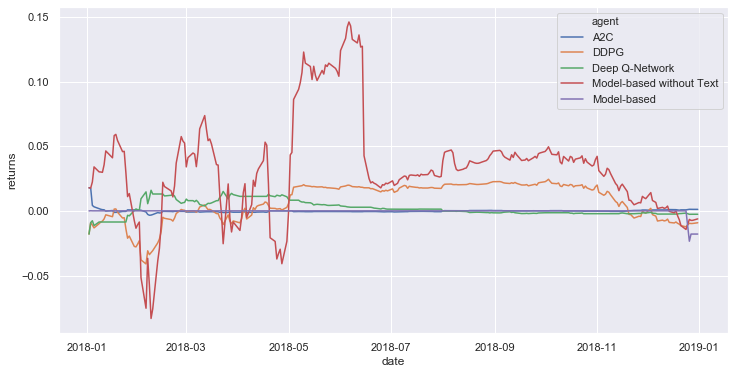

In [235]:
sns.lineplot('date', 'returns', data=test_history[test_history['ticker'] == 'AAPL'],
            hue='agent')

In [90]:
test_history = test_history.drop(['episode'], axis=1)

In [244]:
test_history = test_history.sort_values(['agent', 'ticker', 'date'])

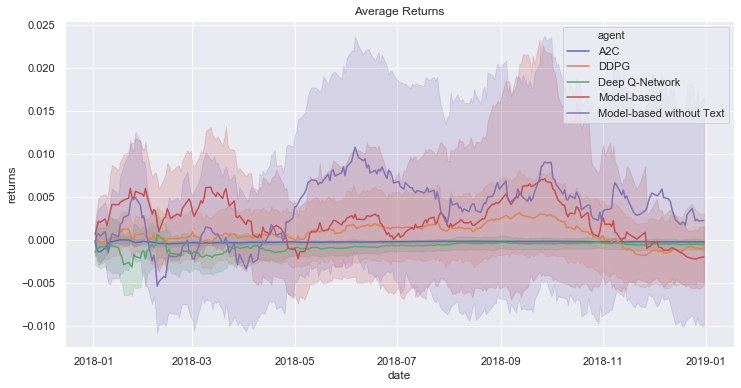

In [245]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 6)
plt.gcf().clear()
fig = plt.figure(1)

ax = sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief',)
ax.set_title('Average Returns')
ax.grid('on')

# fig.savefig('plots/average-returns-all.svg')
fig.savefig('plots/average-returns-all.png')

In [105]:
# sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief')
# plt.title('Average Returns')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('plots/average-returns-all.svg')

In [18]:
test_history.columns

Index(['date', 'ticker', 'rewards', 'actions', 'returns', 'prices', 'mode',
       't', 'episode', 'agent'],
      dtype='object')

# Volatility in Test Set Performance

In [236]:
test_vol_history = test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).std().reset_index()
test_vol_history.agent.unique()
# test_history['vol_returns'] = test_history.groupby('agent')['returns'].rolling(14).std()
# test_history[['date', 'vol_returns', 'agent']]

array(['A2C', 'DDPG', 'Deep Q-Network', 'Model-based',
       'Model-based without Text'], dtype=object)

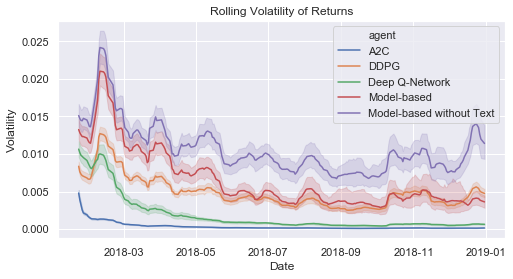

In [237]:
rcParams['figure.figsize'] = (8, 4)
sns.lineplot('Date', 'returns', data=test_vol_history, hue='agent', legend='brief')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Volatility')
plt.title('Rolling Volatility of Returns')
plt.savefig('plots/volatility-all.svg')
plt.savefig('plots/volatility-all.png')

In [240]:
def sharpe(y):
    return (y.mean() / (y.std() + 1e-6))

test_sharpe_history = test_history.groupby(['agent', 'ticker'])['returns'].rolling(60).apply(sharpe).reset_index()
test_sharpe_history[60:80]

,agent,ticker,Date,returns
60,A2C,A,2018-03-29,-1.801834
61,A2C,A,2018-04-02,-1.808279
62,A2C,A,2018-04-03,-1.865800
63,A2C,A,2018-04-04,-1.907844
64,A2C,A,2018-04-05,-1.914470
65,A2C,A,2018-04-06,-2.168942
66,A2C,A,2018-04-09,-2.258882
67,A2C,A,2018-04-10,-2.300911
68,A2C,A,2018-04-11,-2.446961
69,A2C,A,2018-04-12,-2.549539


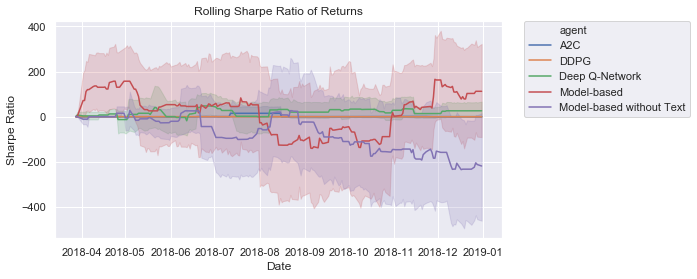

In [241]:
sns.lineplot('Date', 'returns', data=test_sharpe_history, hue='agent')
plt.ylabel('Sharpe Ratio')
plt.title('Rolling Sharpe Ratio of Returns')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.ylim((-20,20))
# plt.savefig('plots/sharpe-all.png')

In [174]:
test_history[test_history.agent != 'DDPG'].groupby(['agent', 'actions'])['returns'].median()
# sns.catplot(x='actions', y='returns',
#             hue='agent', kind='box', data=test_history)

agent                     actions
A2C                       -1.0      -0.000154
                           0.0      -0.000148
                           1.0      -0.000227
Deep Q-Network            -1.0      -0.000658
                           0.0       0.000000
                           1.0      -0.000141
Model-based               -1.0      -0.003830
                           0.0       0.000000
                           1.0       0.003183
Model-based without Text  -1.0      -0.013863
                           0.0       0.000000
                           1.0       0.003176
Name: returns, dtype: float64

In [177]:
test_history[test_history.agent != 'DDPG'].groupby(['agent', 'actions'])['returns'].max()

agent                     actions
A2C                       -1.0       0.161867
                           0.0       0.021654
                           1.0       0.064193
Deep Q-Network            -1.0       0.189507
                           0.0       0.076091
                           1.0       0.190209
Model-based               -1.0       0.546925
                           0.0       0.209946
                           1.0       1.112272
Model-based without Text  -1.0       1.665119
                           0.0       0.222164
                           1.0       1.399679
Name: returns, dtype: float64

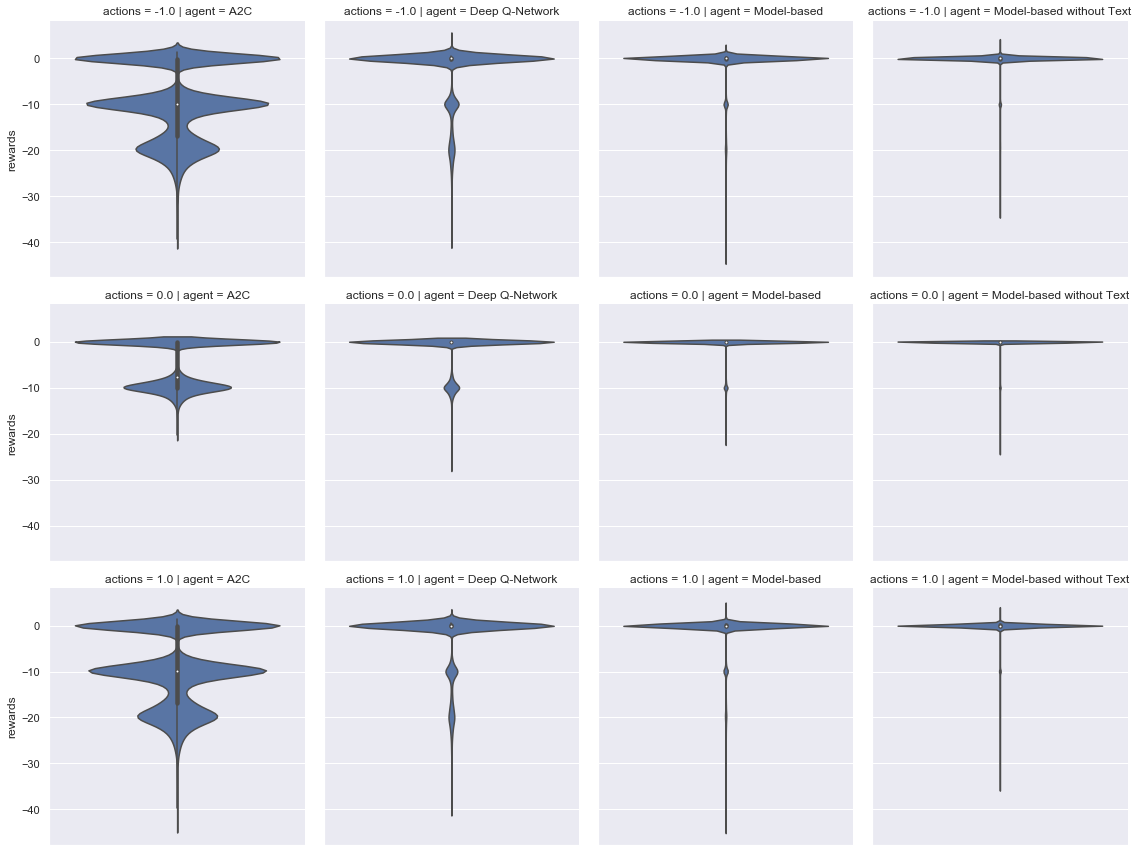

In [194]:
sns.catplot(data=test_history[~test_history.agent.isin(['DDPG'])],
           row="actions", y="rewards", col="agent", kind="violin",
           height=4, aspect=1)

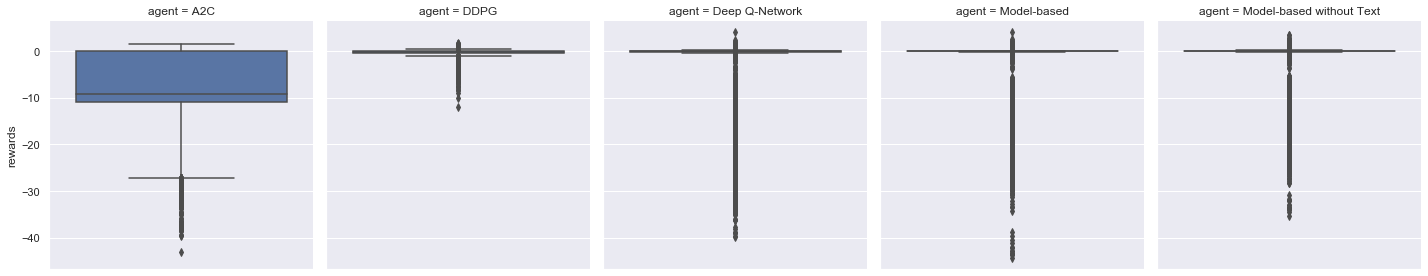

In [203]:
sns.catplot(data=test_history, y="rewards", col="agent",
            kind="box", height=4, aspect=1)